# Dogs vs. Cats. Augmentation.

В этом домашнем задании вам предлогается сравнить несколько стратегий аугментации. Задача достачно простая и чтобы сравнение имело смысл, мы не будем брать готовые архитектуры, а будем обучать свою с нуля.

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

Ваша задача реализовать 5 функций для аугментации и сравнить между собой качество моделей, которые обучались с различными аугментациями.

In [ ]:
def flip(x, y):
    # отзеркаливание вдоль оси x картинки
    pass

def rotation(x, y):
    # вращение картинки, но при этом не очень большое
    pass

def crop(x, y):
    # вырезание случайного прямоугольника
    pass

def mixup(x, y):
    # смешивание двух картинок со случайным весом alpha.
    # target при этом тоже должен смешиваться. То есть если вы смешали собаку и кота с весами 0.75 и 0.25.
    # То кросс-энтропия должна считаться для таргетов 0.75 и 0.25
    pass

def cutmix(x, y):
    # вырезание кусочка из одной картинки и вставка в другую картинку.
    # target тоже должны смешиваться
    # не забудьте убедиться, что лосс считается правильно
    # ссылка на статью: http://openaccess.thecvf.com/content_ICCV_2019/papers/Yun_CutMix_Regularization_Strategy_to_Train_Strong_Classifiers_With_Localizable_Features_ICCV_2019_paper.pdf
    pass

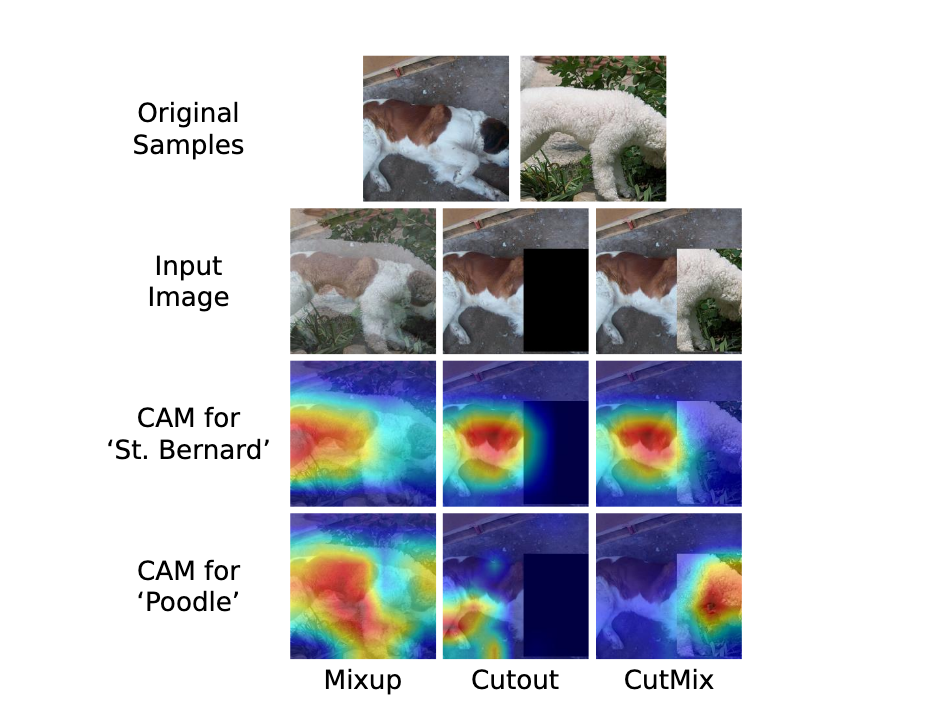

In [1]:
from IPython.display import Image
Image(filename='augs.png')

In [ ]:
AUGMENTATIONS = {
    'flip': flip,
    'rotation': rotation,
    'crop': crop,
    'mixup': mixup,
    'cutmix': cutmix
}

In [ ]:
import re
from random import shuffle
from glob import glob

train_files = glob('dogs-vs-cats-redux-kernels-edition/train/*.jpg')
test_files = glob('dogs-vs-cats-redux-kernels-edition/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32, augmentation_strategies=[]):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])

            
            # этот код можно (и вероятно нужно) переписать, если вам удобнее работать с каждым объектом по отдельности
            for strategy in augmentation_strategies:
                x, y = AUGMENTATIONS[strategy](x, y)
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Определяем модель
Напишите сверточную нейронную сеть с 5-6 слоями. В конце вставьте полносвязный слой с одним выходом и оберните его в сигмоиду.

In [ ]:
# TODO: your code here
model = None

## Компилируем модель и запускаем обучение

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [ ]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=100,  # число эпох обучения
        validation_data=validation_data)

In [ ]:
model.save('cats-dogs-vgg16.hdf5')

# Задание

Обучите 3 модели.
1. Выключить аугментацию
2. Включить flip, rotation, crop
3. Включить всё

Сравните ROC-AUC на тестовой выборке.

При реализации mixup и cutmix немного перепишете чтение данных с диска. Для каждого примера в батче нужно находить случайную пару из датасета.

## Предсказания на проверочной выборке

In [ ]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);